In [59]:
import pandas as pd
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
from tqdm import tqdm_notebook
from scipy.linalg import svd
import catboost

%matplotlib inline

## Подготовка данных

### "Схлопывание" повторяющихся действий пользователей

Для каждого пользователя посчитаем количество того, сколько раз он взаимодействовал с каждой категорией товара в данных транзакций.

In [2]:
path_transactions = r"C:\Users\kiril\OneDrive\Рабочий стол\Вышка\КР-ВКР\Курсовая\3 курс\RecommendationSystem\model\data\transactions.csv"
path_clients = r"C:\Users\kiril\OneDrive\Рабочий стол\Вышка\КР-ВКР\Курсовая\3 курс\RecommendationSystem\model\data\clients.csv"
path_categories = r"C:\Users\kiril\OneDrive\Рабочий стол\Вышка\КР-ВКР\Курсовая\3 курс\RecommendationSystem\model\data\categories.csv"

In [3]:
transactions = pd.read_csv(path_transactions)
transactions.head()

,Unnamed: 0,client_id,product_category,product_company,subtype,amount,date,transaction_type
0,34478,37,29,NaN,Автоплатеж,1209,2020-01-01 00:00:00,Negative
1,65406,71,4,YouTube Music,Подписка,169,2020-01-01 00:00:00,Negative
2,82186,88,29,NaN,Автоплатеж,3711,2020-01-01 00:00:00,Negative
3,83113,89,29,NaN,Автоплатеж,6443,2020-01-01 00:00:00,Negative
4,131373,141,29,NaN,Автоплатеж,7319,2020-01-01 00:00:00,Negative


In [4]:
transactions.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 929135 entries, 0 to 929134
Data columns (total 8 columns):
Unnamed: 0          929135 non-null int64
client_id           929135 non-null int64
product_category    929135 non-null int64
product_company     644651 non-null object
subtype             929135 non-null object
amount              929135 non-null int64
date                929135 non-null object
transaction_type    929135 non-null object
dtypes: int64(4), object(4)
memory usage: 56.7+ MB


In [5]:
transactions.rename(columns={'Unnamed: 0': 'id'}, inplace=True)

In [6]:
transactions.product_category = transactions.product_category.astype('str')

In [7]:
transactions.date = pd.to_datetime(transactions.date)

In [8]:
transactions.dtypes

id                           int64
client_id                    int64
product_category            object
product_company             object
subtype                     object
amount                       int64
date                datetime64[ns]
transaction_type            object
dtype: object

In [9]:
clients = pd.read_csv(path_clients)
clients.head()

,id,fullname,address,phone_number,email,workplace,birthdate,registration_date,gender,income,expenses,credit,deposit
0,1,Волкова Фаина Афанасьевна,"с. Новосибирск, наб. Привокзальная, д. 58 к. 5...",8 (475) 014-6494,wkirillov@rambler.ru,"ст. Кировск (Мурм.), ш. Коммуны, д. 238 стр. 3...",1966-09-07,2017-01-10,F,230910.0,61975,1.0,NaN
1,2,Пелагея Вячеславовна Галкина,"клх Белокуриха, ш. Комсомольское, д. 701 стр. ...",+7 (981) 576-1146,bogdanovmoke@rambler.ru,"г. Елабуга, бул. 60 лет Октября, д. 5, 070955",1987-05-23,2016-07-14,F,NaN,75232,NaN,NaN
2,3,Валентина Игоревна Фомина,"к. Усть-Катав, бул. Восточный, д. 292 стр. 3, ...",+7 (920) 068-58-36,mjasnikovvalentin@mail.ru,"г. Сосновый Бор, алл. Лесхозная, д. 146, 139446",1974-06-15,2017-10-18,F,NaN,88813,NaN,NaN
3,4,тов. Воронцова Фёкла Федоровна,"клх Новая Игирма, алл. Пограничная, д. 6/6, 73...",8 334 398 3828,martin85@rambler.ru,"клх Котельнич, бул. Серафимовича, д. 97, 753076",1979-10-19,2012-08-25,F,NaN,55167,NaN,NaN
4,5,Филипп Дмитриевич Воронцов,"к. Ребриха, пр. Свободы, д. 54, 466509",8 (296) 455-0453,jan_07@rambler.ru,"клх Карабудахкент, ул. Абрикосовая, д. 3 к. 19...",1986-08-14,2017-03-15,M,NaN,85106,NaN,NaN


In [10]:
categories = pd.read_csv(path_categories)
categories.head()

,id,name,description,mcc-code
0,1,Каршеринг,Краткосрочная аренда авто с оплатой по минутам...,"7512, 4121"
1,2,Супермаркеты,Покупки в супермаркетах и продуктовых магазинах,"5297, 5298, 5300, 5411, 5412, 5422, 5441, 5451..."
2,3,Такси,Услуги такси (каршеринг не входит в данную кат...,4121
3,4,Музыка,Покупки в магазинах музыки и музыкальных инстр...,"5733, 5735"
4,5,Фастфуд,Покупки в ресторанах быстрого питания,5814


In [11]:
categories.id = categories.id.astype('str')
categories['mcc-code'] = categories['mcc-code'].fillna('no_code')
categories['mcc-code'] = categories['mcc-code'].astype('str')
categories = categories.rename(columns={'id': 'product_category'})

In [12]:
clients_id = clients[['id']]
clients_id.head()

,id
0,1
1,2
2,3
3,4
4,5


In [13]:
transactions_part = transactions[['client_id', 'product_category', 'date']]
transactions_part.head()

,client_id,product_category,date
0,37,29,2020-01-01
1,71,4,2020-01-01
2,88,29,2020-01-01
3,89,29,2020-01-01
4,141,29,2020-01-01


In [14]:
data = transactions_part.groupby(['client_id', 'product_category'], as_index=False) \
    .agg({'date': 'count'}) \
    .rename(columns={'date': 'purchase_count'})

In [15]:
data.head()

,client_id,product_category,purchase_count
0,1,10,18
1,1,11,14
2,1,13,23
3,1,14,19
4,1,16,10


### Фильтрация неактивных пользователей

Отфильтруем пользователей, которые взаимодействовали не больше, чем с 4 категориями товаров и услуг.

In [16]:
users_interactions = data \
    .groupby('client_id', as_index=False) \
    .agg({'product_category': 'count'}) \
    .rename(columns={'product_category': 'unique_categories'})
users_interactions.head()

,client_id,unique_categories
0,1,18
1,2,21
2,3,24
3,4,21
4,5,19


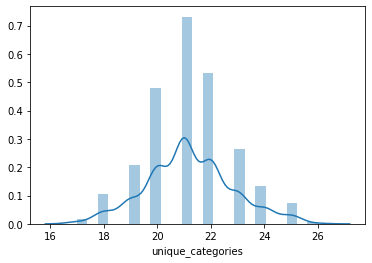

In [17]:
sns.distplot(users_interactions.unique_categories);

In [18]:
users_with_enough_interactions = users_interactions.query('unique_categories > 4')['client_id']
users_with_enough_interactions

0         1
1         2
2         3
3         4
4         5
       ... 
995     996
996     997
997     998
998     999
999    1000
Name: client_id, Length: 1000, dtype: int64

In [19]:
print(f'Всего пользователей: {users_interactions.shape[0]}')
print(f'Пользователей по крайней мере с 5 взаимодействиями: {users_with_enough_interactions.shape[0]}')

Всего пользователей: 1000
Пользователей по крайней мере с 5 взаимодействиями: 1000


Получаем, что пользователей меньше, чем с 5 взаимодействиями нет.

### Нормализация

В качестве нормализации воспользуемся MinMaxScaler.

In [20]:
data = data.assign(purchase_normalize = (data.purchase_count - data.purchase_count.min()) / (data.purchase_count.max() - data.purchase_count.min()))
data.head()

,client_id,product_category,purchase_count,purchase_normalize
0,1,10,18,0.042607
1,1,11,14,0.032581
2,1,13,23,0.055138
3,1,14,19,0.045113
4,1,16,10,0.022556


### Разбиение выборки на тренировочную и тестовую

Произведем разбиение выборки на обучение и контроль по времени. Перед этим возьмем последнее время взаимодействия пары client_id и product_category.

In [21]:
transactions_last_date = transactions_part \
    .groupby(['client_id', 'product_category'], as_index=False) \
    .date \
    .last()
transactions_last_date.head()

,client_id,product_category,date
0,1,10,2020-12-22 02:33:13
1,1,11,2020-12-22 10:20:44
2,1,13,2020-12-29 09:07:06
3,1,14,2020-12-31 06:49:11
4,1,16,2020-12-29 03:38:07


In [22]:
data = data \
    .merge(transactions_last_date, on=['client_id', 'product_category']) \
    .rename(columns={'date': 'last_date'})
data.head()

,client_id,product_category,purchase_count,purchase_normalize,last_date
0,1,10,18,0.042607,2020-12-22 02:33:13
1,1,11,14,0.032581,2020-12-22 10:20:44
2,1,13,23,0.055138,2020-12-29 09:07:06
3,1,14,19,0.045113,2020-12-31 06:49:11
4,1,16,10,0.022556,2020-12-29 03:38:07


In [23]:
split_date = '2020-12-30'
data_train = data.query('last_date < @split_date').copy()
data_test = data.query('last_date >= @split_date').copy()

print(f'Всего взаимодействий: {data.shape[0]}')
print(f'Доля взаимодействий в тренировочной выборке: {round(data_train.shape[0] / data.shape[0], 1)} ({data_train.shape[0]})')
print(f'Доля взаимодействий в тестовой выборке: {round(data_test.shape[0] / data.shape[0], 1)} ({data_test.shape[0]})')

Всего взаимодействий: 21201
Доля взаимодействий в тренировочной выборке: 0.8 (17658)
Доля взаимодействий в тестовой выборке: 0.2 (3543)


Для удобства подсчета качества запишем данные в формате, где строка соответствует пользователю, а столбцы будут истинными метками и предсказаниями в виде списков

In [24]:
data_true = (
    data_train
    .groupby('client_id')['product_category'].agg(lambda x: list(x))
    .reset_index()
    .rename(columns={'product_category': 'true_train'})
    .set_index('client_id')
)

data_true['true_test'] = (
    data_test
    .groupby('client_id')['product_category'].agg(lambda x: list(x))
)

Заполним пропуски пустыми списками.

In [25]:
data_true.loc[pd.isnull(data_true.true_test), 'true_test'] = [
    list() for x in range(len(data_true.loc[pd.isnull(data_true.true_test), 'true_test']))]

In [26]:
data_true.head(1)

,true_train,true_test
client_id,,
1,"[10, 11, 13, 16, 17, 18, 19, 2, 20, 21, 4, 6, ...","[14, 28, 5, 9]"


## Моделирование и оценка

Для каждого пользователя будем предсказывать только одну категорию товара или услуги в связи тем, что только реклама одной категории товара или услуги может быть показана пользователю в приложении.

В качестве метрик качества моделей будем использовать: precision@k, 

In [27]:
def calc_precision(column):
    return (
        data_true
        .apply(
            lambda row:
            len(set(row['true_test']).intersection(
                set(row[column]))) /
            min(len(row['true_test']) + 0.001, 10.0),
            axis=1)).mean()

### Baseline (модель по полуярности)

Посчитаем популярность каждой категории, как сумму всех количеств взаимодействия с ней, и отсортируем категории по их популярности.

In [28]:
top_k = 1 # количество категорий, которое нужно предсказать пользователю

In [29]:
popular_category = (
    data_train
    .groupby('product_category', as_index=False)
    .agg({'purchase_normalize': 'sum'})
    .rename(columns={'purchase_normalize': 'purchase_total'})
    .sort_values('purchase_total', ascending=False)
    .product_category.values
)
popular_category

array(['5', '28', '6', '2', '3', '1', '7', '11', '8', '13', '10', '14',
       '9', '15', '17', '21', '20', '16', '18', '19', '4', '29', '12',
       '26', '27', '24', '25', '22', '23'], dtype=object)

In [30]:
print(f"Наиболее популярной категорией является: {categories.query('product_category == @popular_category[0]')['name'].values[0]}")
print(f"Наименее популярной категорией является: {categories.query('product_category == @popular_category[-1]')['name'].values[0]}")

Наиболее популярной категорией является: Фастфуд
Наименее популярной категорией является: Автоуслуги


Делаем предсказания для каждого пользователя.

#### Без учета того, что пользователь уже приобретал

В этом случае мы будем пользователю также рекомендовать те категории товаров и услуг, которые он приобретал. В этом случае каждому пользователю предлагаем самую популярную категорию.

In [31]:
data_true['prediction_popular_without'] = np.resize(popular_category[:top_k], (data_true.shape[0], 1))

In [32]:
data_true.head()

,true_train,true_test,prediction_popular_without
client_id,,,
1,"[10, 11, 13, 16, 17, 18, 19, 2, 20, 21, 4, 6, ...","[14, 28, 5, 9]",5
2,"[1, 10, 11, 13, 14, 15, 16, 17, 18, 19, 2, 20,...",[5],5
3,"[10, 11, 13, 15, 16, 17, 18, 19, 20, 21, 22, 2...","[1, 14, 2, 5, 6, 9]",5
4,"[10, 13, 14, 16, 17, 18, 19, 2, 20, 21, 23, 24...","[11, 28, 6, 9]",5
5,"[1, 11, 13, 14, 16, 17, 18, 19, 2, 20, 21, 28,...","[10, 6]",5


In [33]:
calc_precision('prediction_popular_without')

0.14890538174745013

#### С учетом того, что пользователь уже приобретал

Теперь рассмотрим вариант, когда рекомендуем пользователю только те категории, которые он еще не приобретал.

In [34]:
data_true['prediction_popular_with'] = (
    data_true.true_train
    .apply(
        lambda x:
        popular_category[~np.in1d(popular_category, x)][:top_k]
    )
)

In [35]:
data_true.head()

,true_train,true_test,prediction_popular_without,prediction_popular_with
client_id,,,,
1,"[10, 11, 13, 16, 17, 18, 19, 2, 20, 21, 4, 6, ...","[14, 28, 5, 9]",5,[5]
2,"[1, 10, 11, 13, 14, 15, 16, 17, 18, 19, 2, 20,...",[5],5,[5]
3,"[10, 11, 13, 15, 16, 17, 18, 19, 20, 21, 22, 2...","[1, 14, 2, 5, 6, 9]",5,[5]
4,"[10, 13, 14, 16, 17, 18, 19, 2, 20, 21, 23, 24...","[11, 28, 6, 9]",5,[28]
5,"[1, 11, 13, 14, 16, 17, 18, 19, 2, 20, 21, 28,...","[10, 6]",5,[6]


In [36]:
calc_precision('prediction_popular_with')

0.33836705930191663

### Коллаборативная фильтрация

In [37]:
data_matrix = pd.pivot_table(data, index='client_id', columns='product_category', values='purchase_normalize', fill_value=0)
data_matrix.head()

product_category,1,10,11,12,13,14,15,16,17,18,...,27,28,29,3,4,5,6,7,8,9
client_id,,,,,,,,,,,,,,,,,,,,,
1,0.000000,0.042607,0.032581,0.0,0.055138,0.045113,0.000000,0.022556,0.012531,0.040100,...,0.0,0.275689,0.000000,0.000000,0.027569,0.378446,0.974937,0.065163,0.060150,0.047619
2,0.072682,0.050125,0.045113,0.0,0.045113,0.042607,0.107769,0.020050,0.025063,0.017544,...,0.0,0.298246,0.000000,0.100251,0.010025,0.338346,0.756892,0.030075,0.032581,0.062657
3,0.095238,0.037594,0.062657,0.0,0.040100,0.040100,0.105263,0.017544,0.022556,0.017544,...,0.0,0.295739,0.000000,0.090226,0.027569,0.395990,0.769424,0.072682,0.042607,0.052632
4,0.000000,0.047619,0.040100,0.0,0.025063,0.035088,0.000000,0.020050,0.005013,0.040100,...,0.0,0.248120,0.027569,0.000000,0.012531,0.293233,0.927318,0.042607,0.067669,0.050125
5,0.110276,0.082707,0.057644,0.0,0.062657,0.070175,0.000000,0.015038,0.025063,0.025063,...,0.0,0.255639,0.000000,0.107769,0.000000,0.385965,0.979950,0.067669,0.052632,0.065163


#### Memory-dased

In [38]:
matrix = data_matrix.values

In [39]:
similarity_users = np.zeros((len(matrix), len(matrix)))

for i in tqdm_notebook(range(len(matrix)-1)):
    for j in range(i+1, len(matrix)):
        
        # nonzero elements of two users
        mask_uv = (matrix[i] != 0) & (matrix[j] != 0)
        
        # continue if no intersection
        if np.sum(mask_uv) == 0:
            continue
            
        # get nonzero elements
        ratings_v = matrix[i, mask_uv]
        ratings_u = matrix[j, mask_uv]
        
        # for nonzero std
        if len(np.unique(ratings_v)) < 2 or len(np.unique(ratings_u)) < 2:
            continue
        similarity_users[i,j] = np.corrcoef(ratings_v, ratings_u)[0, 1]
        similarity_users[j,i] = similarity_users[i,j]

In [40]:
prediction_user_based = []
for i in tqdm_notebook(range(len(similarity_users))):
    users_sim = similarity_users[i] > 0
    if len(users_sim) == 0:
        prediction_user_based.append([])
    else:
        tmp_recommend = np.argsort(matrix[users_sim].sum(axis=0))[::-1]
        tmp_recommend = data_matrix.columns[tmp_recommend]
        recommend = np.array(tmp_recommend)[~np.in1d(tmp_recommend, data_true.iloc[i])][:10]
        prediction_user_based.append(list(recommend))

data_true['prediction_user_based'] = prediction_user_based

C:\Users\kiril\Anaconda3\lib\site-packages\numpy\lib\arraysetops.py:569: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  mask |= (ar1 == a)


In [41]:
calc_precision('prediction_user_based')

0.5111497857838353

#### Latent Factor Model

In [42]:
U, sigma, V = svd(data_matrix)
print(data_matrix.shape, U.shape, sigma.shape, V.shape)

(1000, 29) (1000, 1000) (29,) (29, 29)


In [43]:
Sigma = np.zeros((1000, 29))
Sigma[:29, :29] = np.diag(sigma)

new_data_matrix = U.dot(Sigma).dot(V)
print(sum(sum((new_data_matrix - data_matrix.values) ** 2)))

6.385793947506476e-26


In [44]:
K = 25
sigma[K:] = 0
Sigma = np.zeros((1000, 29))
Sigma[:29, :29] = np.diag(sigma)

In [45]:
new_data_matrix = U.dot(Sigma).dot(V)
print(sum(sum((new_data_matrix - data_matrix.values) ** 2)))
print(sum(sum((data_matrix.values.mean() - data_matrix.values) ** 2)))

0.0005187998118375348
809.8458534297037


In [46]:
new_data_matrix = pd.DataFrame(new_data_matrix, index=data_matrix.index, columns=data_matrix.columns)

predictions = []
for client_id in tqdm_notebook(data_true.index):
    prediction = (
        new_data_matrix
        .loc[client_id]
        .sort_values(ascending=False)
        .index.values
    )
    
    predictions.append(
        list(prediction[~np.in1d(
            prediction,
            data_true.loc[client_id, 'true_train'])])[:top_k])

data_true['prediction_svd'] = predictions

In [47]:
calc_precision('prediction_svd')

0.3416977838090405

### Контентная модель

In [48]:
test_client_id = np.repeat(data_true.index, len(data_matrix.columns)) 
test_product_category = list(data_matrix.columns) * len(data_true)
test = pd.DataFrame(
    np.array([test_client_id, test_product_category]).T,
    columns=['client_id', 'product_category'])

data_train_content = pd.concat((
    data_train,
    test.loc[
        np.random.permutation(test.index)[
            :4*len(data_train)]]), ignore_index=True)
data_train.purchase_normalize.fillna(0, inplace=True)

C:\Users\kiril\Anaconda3\lib\site-packages\ipykernel_launcher.py:11: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.

  # This is added back by InteractiveShellApp.init_path()


In [49]:
data_train_content = data_train_content.merge(categories, how='left', on='product_category')
data_test_content = data_test.merge(categories, how='left', on='product_category')

In [50]:
data_train_content.drop(columns=['purchase_count', 'name', 'description'], inplace=True)
data_test_content.drop(columns=['purchase_count', 'name', 'description'], inplace=True)

In [51]:
data_train_content.head()

,client_id,last_date,product_category,purchase_normalize,mcc-code
0,1,2020-12-22 02:33:13,10,0.042607,"7911, 7922, 7929, 7932, 7933, 7941, 7991, 7992..."
1,1,2020-12-22 10:20:44,11,0.032581,"5977, 7230, 7297, 7298"
2,1,2020-12-29 09:07:06,13,0.055138,"5094, 5137, 5139, 5611, 5621, 5631, 5641, 5651..."
3,1,2020-12-29 03:38:07,16,0.022556,"5995, 0742"
4,1,2020-11-11 05:21:46,17,0.012531,"1520, 1711, 1731, 1740, 1750, 1761, 1771, 1799..."


In [52]:
data_test_content.head()

,client_id,product_category,purchase_normalize,last_date,mcc-code
0,1,14,0.045113,2020-12-31 06:49:11,"5811, 5812, 5813"
1,1,28,0.275689,2020-12-31 05:48:08,no_code
2,1,5,0.378446,2020-12-30 01:48:37,5814
3,1,9,0.047619,2020-12-30 23:54:16,"2741, 5111, 5192, 5942, 5994"
4,2,5,0.338346,2020-12-30 05:57:08,5814


In [81]:
features_start = len(data_train_content.columns) - 1
features_start

4

In [54]:
test_client_id = np.repeat(data_true.index, len(categories)) 
test_product_category = list(categories.product_category) * len(data_true)
test = pd.DataFrame(
    np.array([test_client_id, test_product_category]).T,
    columns=['client_id', 'product_category'])
test = test.merge(categories, how='left', on='product_category')
test.drop(columns=['name', 'description'], inplace=True)

In [55]:
test.head()

,client_id,product_category,mcc-code
0,1,1,"7512, 4121"
1,1,2,"5297, 5298, 5300, 5411, 5412, 5422, 5441, 5451..."
2,1,3,4121
3,1,4,"5733, 5735"
4,1,5,5814


In [56]:
def mcc_count(column_value):
    if column_value == 'no_code':
        return 0
    else:
        mcc_count = len(column_value.split(', '))
        return mcc_count

In [58]:
data_train_content['mcc-code'] = data_train_content['mcc-code'].apply(mcc_count)
test['mcc-code'] = test['mcc-code'].apply(mcc_count)

In [82]:
X_train_content = data_train_content[data_train_content.columns[features_start:]]
y_train_content = np.array(data_train_content.purchase_normalize > 0, dtype=int)

In [84]:
model = catboost.CatBoostClassifier()
model.fit(X_train_content, y_train_content)

Learning rate set to 0.053158
0:	learn: 0.6862729	total: 13.2ms	remaining: 13.2s
1:	learn: 0.6800018	total: 25.4ms	remaining: 12.7s
2:	learn: 0.6736487	total: 38.2ms	remaining: 12.7s
3:	learn: 0.6692876	total: 50ms	remaining: 12.5s
4:	learn: 0.6643423	total: 64ms	remaining: 12.7s
5:	learn: 0.6593646	total: 77.3ms	remaining: 12.8s
6:	learn: 0.6555106	total: 91.6ms	remaining: 13s
7:	learn: 0.6535208	total: 101ms	remaining: 12.5s
8:	learn: 0.6510575	total: 111ms	remaining: 12.3s
9:	learn: 0.6488267	total: 121ms	remaining: 12s
10:	learn: 0.6462643	total: 132ms	remaining: 11.9s
11:	learn: 0.6446878	total: 145ms	remaining: 12s
12:	learn: 0.6433458	total: 156ms	remaining: 11.8s
13:	learn: 0.6414900	total: 168ms	remaining: 11.8s
14:	learn: 0.6398819	total: 182ms	remaining: 12s
15:	learn: 0.6388731	total: 196ms	remaining: 12.1s
16:	learn: 0.6371778	total: 210ms	remaining: 12.1s
17:	learn: 0.6359698	total: 223ms	remaining: 12.1s
18:	learn: 0.6352181	total: 235ms	remaining: 12.1s
19:	learn: 0.634

160:	learn: 0.6213896	total: 1.8s	remaining: 9.41s
161:	learn: 0.6213867	total: 1.82s	remaining: 9.41s
162:	learn: 0.6213867	total: 1.83s	remaining: 9.38s
163:	learn: 0.6213794	total: 1.84s	remaining: 9.37s
164:	learn: 0.6213791	total: 1.85s	remaining: 9.35s
165:	learn: 0.6213785	total: 1.86s	remaining: 9.33s
166:	learn: 0.6213683	total: 1.87s	remaining: 9.32s
167:	learn: 0.6213593	total: 1.88s	remaining: 9.3s
168:	learn: 0.6213593	total: 1.89s	remaining: 9.27s
169:	learn: 0.6213584	total: 1.9s	remaining: 9.26s
170:	learn: 0.6213566	total: 1.91s	remaining: 9.24s
171:	learn: 0.6213566	total: 1.92s	remaining: 9.22s
172:	learn: 0.6213546	total: 1.93s	remaining: 9.21s
173:	learn: 0.6213545	total: 1.93s	remaining: 9.18s
174:	learn: 0.6213535	total: 1.94s	remaining: 9.16s
175:	learn: 0.6213457	total: 1.95s	remaining: 9.15s
176:	learn: 0.6213449	total: 1.96s	remaining: 9.13s
177:	learn: 0.6213446	total: 1.97s	remaining: 9.12s
178:	learn: 0.6213440	total: 1.98s	remaining: 9.1s
179:	learn: 0.62

319:	learn: 0.6212062	total: 3.42s	remaining: 7.26s
320:	learn: 0.6212056	total: 3.43s	remaining: 7.25s
321:	learn: 0.6212056	total: 3.44s	remaining: 7.24s
322:	learn: 0.6212055	total: 3.45s	remaining: 7.24s
323:	learn: 0.6212055	total: 3.46s	remaining: 7.22s
324:	learn: 0.6212048	total: 3.48s	remaining: 7.22s
325:	learn: 0.6212042	total: 3.49s	remaining: 7.21s
326:	learn: 0.6212042	total: 3.5s	remaining: 7.2s
327:	learn: 0.6212042	total: 3.51s	remaining: 7.18s
328:	learn: 0.6212042	total: 3.52s	remaining: 7.17s
329:	learn: 0.6212042	total: 3.53s	remaining: 7.16s
330:	learn: 0.6212042	total: 3.54s	remaining: 7.15s
331:	learn: 0.6212040	total: 3.55s	remaining: 7.13s
332:	learn: 0.6212035	total: 3.56s	remaining: 7.13s
333:	learn: 0.6212030	total: 3.57s	remaining: 7.11s
334:	learn: 0.6212030	total: 3.58s	remaining: 7.1s
335:	learn: 0.6212029	total: 3.59s	remaining: 7.1s
336:	learn: 0.6212029	total: 3.6s	remaining: 7.09s
337:	learn: 0.6212025	total: 3.62s	remaining: 7.08s
338:	learn: 0.621

478:	learn: 0.6211961	total: 5.2s	remaining: 5.66s
479:	learn: 0.6211961	total: 5.21s	remaining: 5.65s
480:	learn: 0.6211961	total: 5.22s	remaining: 5.64s
481:	learn: 0.6211961	total: 5.23s	remaining: 5.63s
482:	learn: 0.6211961	total: 5.24s	remaining: 5.61s
483:	learn: 0.6211960	total: 5.25s	remaining: 5.6s
484:	learn: 0.6211960	total: 5.26s	remaining: 5.59s
485:	learn: 0.6211960	total: 5.27s	remaining: 5.58s
486:	learn: 0.6211960	total: 5.29s	remaining: 5.57s
487:	learn: 0.6211960	total: 5.3s	remaining: 5.56s
488:	learn: 0.6211959	total: 5.31s	remaining: 5.55s
489:	learn: 0.6211959	total: 5.32s	remaining: 5.54s
490:	learn: 0.6211959	total: 5.33s	remaining: 5.53s
491:	learn: 0.6211959	total: 5.34s	remaining: 5.51s
492:	learn: 0.6211958	total: 5.35s	remaining: 5.5s
493:	learn: 0.6211958	total: 5.36s	remaining: 5.49s
494:	learn: 0.6211958	total: 5.37s	remaining: 5.48s
495:	learn: 0.6211958	total: 5.38s	remaining: 5.47s
496:	learn: 0.6211958	total: 5.39s	remaining: 5.46s
497:	learn: 0.62

637:	learn: 0.6211946	total: 6.74s	remaining: 3.82s
638:	learn: 0.6211946	total: 6.75s	remaining: 3.81s
639:	learn: 0.6211946	total: 6.76s	remaining: 3.8s
640:	learn: 0.6211946	total: 6.77s	remaining: 3.79s
641:	learn: 0.6211946	total: 6.78s	remaining: 3.78s
642:	learn: 0.6211946	total: 6.79s	remaining: 3.77s
643:	learn: 0.6211946	total: 6.79s	remaining: 3.76s
644:	learn: 0.6211946	total: 6.8s	remaining: 3.75s
645:	learn: 0.6211946	total: 6.81s	remaining: 3.73s
646:	learn: 0.6211945	total: 6.83s	remaining: 3.72s
647:	learn: 0.6211945	total: 6.83s	remaining: 3.71s
648:	learn: 0.6211945	total: 6.84s	remaining: 3.7s
649:	learn: 0.6211945	total: 6.86s	remaining: 3.69s
650:	learn: 0.6211945	total: 6.87s	remaining: 3.68s
651:	learn: 0.6211945	total: 6.88s	remaining: 3.67s
652:	learn: 0.6211945	total: 6.89s	remaining: 3.66s
653:	learn: 0.6211945	total: 6.89s	remaining: 3.65s
654:	learn: 0.6211945	total: 6.91s	remaining: 3.64s
655:	learn: 0.6211945	total: 6.91s	remaining: 3.63s
656:	learn: 0.6

796:	learn: 0.6211942	total: 8.25s	remaining: 2.1s
797:	learn: 0.6211942	total: 8.26s	remaining: 2.09s
798:	learn: 0.6211942	total: 8.27s	remaining: 2.08s
799:	learn: 0.6211942	total: 8.28s	remaining: 2.07s
800:	learn: 0.6211942	total: 8.28s	remaining: 2.06s
801:	learn: 0.6211942	total: 8.29s	remaining: 2.05s
802:	learn: 0.6211942	total: 8.3s	remaining: 2.04s
803:	learn: 0.6211942	total: 8.31s	remaining: 2.03s
804:	learn: 0.6211941	total: 8.32s	remaining: 2.02s
805:	learn: 0.6211941	total: 8.33s	remaining: 2s
806:	learn: 0.6211941	total: 8.34s	remaining: 1.99s
807:	learn: 0.6211941	total: 8.35s	remaining: 1.98s
808:	learn: 0.6211941	total: 8.36s	remaining: 1.97s
809:	learn: 0.6211941	total: 8.37s	remaining: 1.96s
810:	learn: 0.6211941	total: 8.38s	remaining: 1.95s
811:	learn: 0.6211941	total: 8.39s	remaining: 1.94s
812:	learn: 0.6211941	total: 8.4s	remaining: 1.93s
813:	learn: 0.6211941	total: 8.4s	remaining: 1.92s
814:	learn: 0.6211941	total: 8.41s	remaining: 1.91s
815:	learn: 0.62119

955:	learn: 0.6211939	total: 9.77s	remaining: 450ms
956:	learn: 0.6211939	total: 9.78s	remaining: 439ms
957:	learn: 0.6211939	total: 9.79s	remaining: 429ms
958:	learn: 0.6211939	total: 9.8s	remaining: 419ms
959:	learn: 0.6211939	total: 9.81s	remaining: 409ms
960:	learn: 0.6211939	total: 9.82s	remaining: 399ms
961:	learn: 0.6211939	total: 9.83s	remaining: 388ms
962:	learn: 0.6211939	total: 9.84s	remaining: 378ms
963:	learn: 0.6211939	total: 9.85s	remaining: 368ms
964:	learn: 0.6211939	total: 9.86s	remaining: 358ms
965:	learn: 0.6211939	total: 9.87s	remaining: 347ms
966:	learn: 0.6211939	total: 9.88s	remaining: 337ms
967:	learn: 0.6211939	total: 9.89s	remaining: 327ms
968:	learn: 0.6211939	total: 9.9s	remaining: 317ms
969:	learn: 0.6211939	total: 9.91s	remaining: 306ms
970:	learn: 0.6211939	total: 9.92s	remaining: 296ms
971:	learn: 0.6211939	total: 9.93s	remaining: 286ms
972:	learn: 0.6211939	total: 9.94s	remaining: 276ms
973:	learn: 0.6211939	total: 9.95s	remaining: 266ms
974:	learn: 0.

In [92]:
predictions[1]

['17',
 '8',
 '14',
 '18',
 '13',
 '10',
 '9',
 '2',
 '7',
 '15',
 '11',
 '21',
 '26',
 '16',
 '1',
 '4',
 '28',
 '29',
 '3',
 '19',
 '24',
 '25',
 '5',
 '12',
 '20',
 '22',
 '6',
 '27',
 '23']

In [97]:
predictions = model.predict_proba(test[data_train_content.columns[features_start:]])[:, 1]
test['predictions'] = predictions

test = test.sort_values('predictions', ascending=False)
predictions = test.groupby('client_id')['product_category'].agg(list)
tmp_predictions = []

for client_id in tqdm_notebook(data_true.index):
    prediction = np.array(predictions[client_id - 1])
    
    tmp_predictions.append(
        list(prediction[~np.in1d(
            prediction,
            data_true.loc[client_id, 'true_train'])])[:top_k])
    
data_true['prediction_content'] = tmp_predictions

In [98]:
calc_precision('prediction_content')

0.21298056032256338